# Implementing GPT-Newspaper With Deepseek: A Personalized AI-Driven News Platform

GPT-Newspaper is an innovative autonomous agent architecture designed to create personalized news articles tailored to individual user preferences. By leveraging `deepseek-r1:14b` from `ollama` for text generation, GPT-Newspaper revolutionizes the way we consume information—performing everything from searching and curating relevant data to writing, critiquing, and publishing final content. A central feature of this design is the Writer–Critique loop, which iteratively refines article drafts until they meet high-quality standards.

[**GPT Researcher Link**](https://github.com/rotemweiss57/gpt-newspaper?ref=blog.langchain.dev)

## **Agent Workflow Overview**

Here’s a breakdown of the agent workflow from the paper implemented:

- **Search Agent**:  
  This agent gathers initial facts, references, or context based on user input, ensuring the foundation of the article is accurate and relevant.

- **Curator Agent**:  
  The Curator Agent filters and organizes the raw search results, extracting only the most important or relevant points to streamline the content creation process.

- **Writer Agent**:  
  Using the curated information, the Writer Agent drafts an initial version of the article. This draft serves as the starting point for refinement.

- **Critique Agent**:  
  The Critique Agent reviews the draft, offering suggestions or identifying areas that need revision. If changes are required, the process loops back to the Writer Agent for further refinement.

- **Designer Agent**:  
  Once the article is polished, the Designer Agent formats it into a user-friendly layout or style, such as Markdown, ensuring readability and aesthetic appeal.

- **Editor Agent**:  
  The Editor Agent performs a final editorial pass, checking for clarity, grammar, and consistency to ensure the article is publication-ready

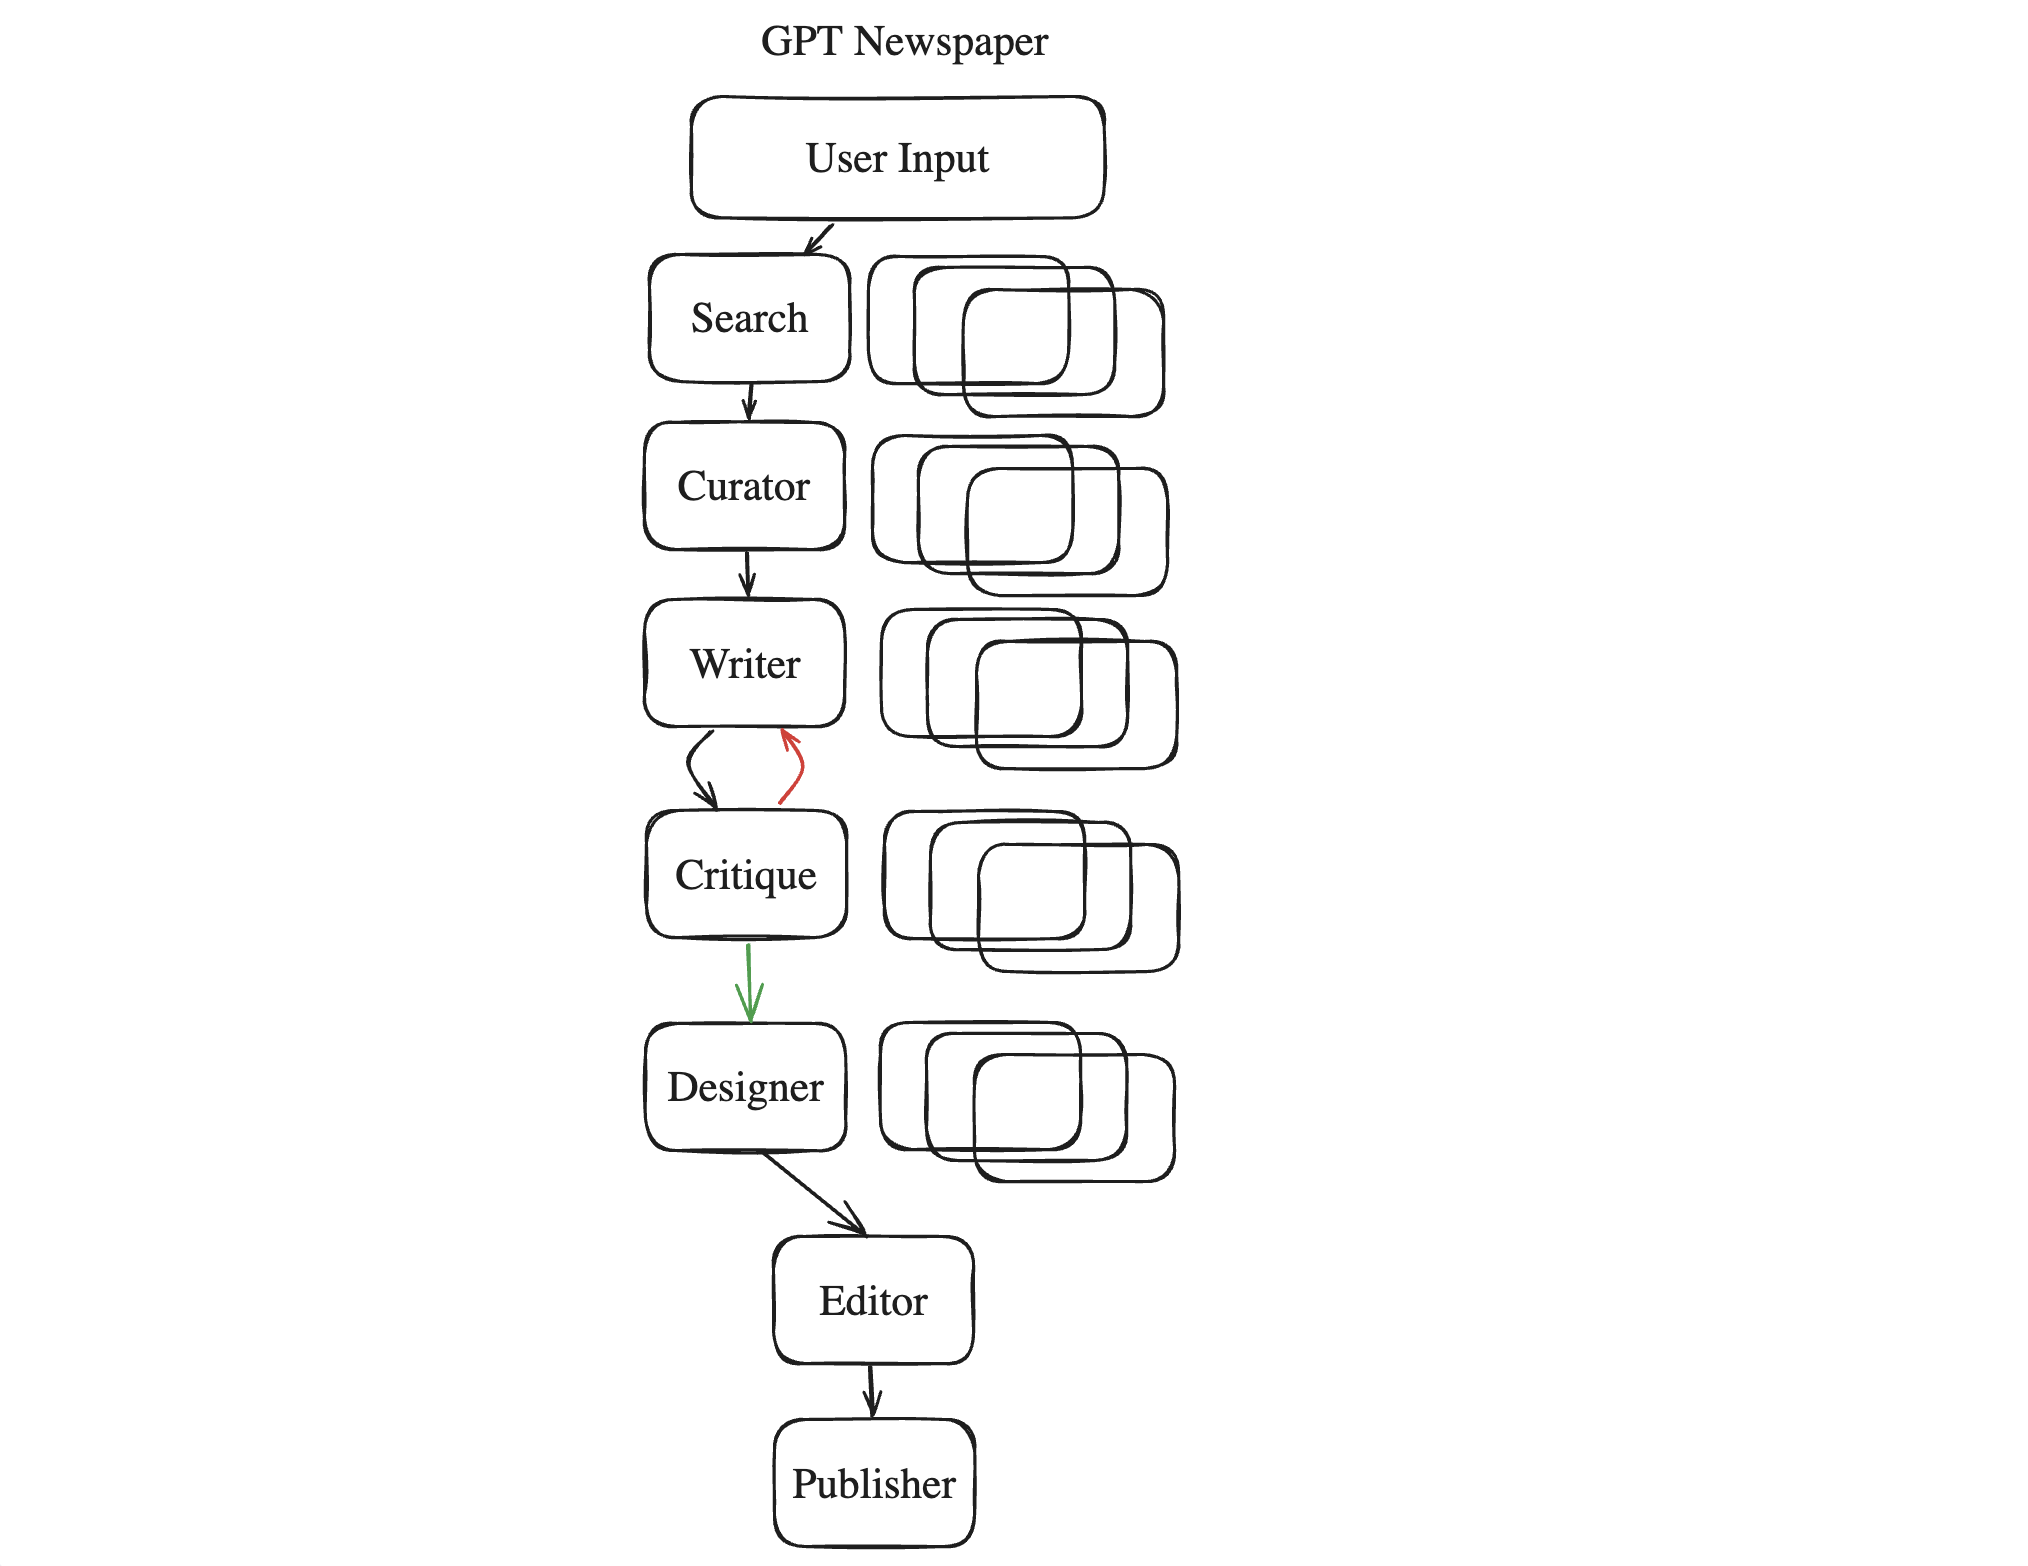

In [9]:
from IPython.display import Image
Image(filename="/Users/noahkostesku/Downloads/gptFlow.png")

## Implementation

In [6]:
import json
import re
from typing import Optional, List
from pydantic import BaseModel, ValidationError
from ollama import AsyncClient

def extract_json_object(text: str) -> str:
    """
    Extracts the first JSON object or array found in the text.
    Returns it as a string.
    Raises ValueError if no valid JSON is found.
    """
    match = re.search(r'(\{.*?\}|\[.*?\])', text, re.DOTALL)
    if match:
        return match.group(1)
    raise ValueError("No valid JSON found in the text")



class ArticleDraft(BaseModel):
    title: str
    body: str

class CritiqueFeedback(BaseModel):
    needs_revision: bool
    suggestions: str


#Gathers initial context or ideas based on user input
class SearchAgent:
    async def search(self, client: AsyncClient, user_input: str) -> str:
        prompt = (
            "You are a specialized 'Search Agent.' Given the user input below, "
            "provide a concise list of relevant facts, references, or context "
            "that could be used in writing an article:\n\n"
            f"User Input: {user_input}\n\n"
            "Return only the relevant facts and context. Do not write an article."
        )
        response = await client.chat(
            model='deepseek-r1:14b',
            messages=[{'role': 'user', 'content': prompt}],
            options={'temperature': 0.2},
        )
        return response.message.content.strip()


#Filters or organizes the search results to ensure only the most important info remains
class CuratorAgent:
    async def curate(self, client: AsyncClient, search_results: str) -> str:
        prompt = (
            "You are a 'Curator Agent.' Given the search results below, "
            "filter out unnecessary details and produce a curated list of key points:\n\n"
            f"Search Results:\n{search_results}\n\n"
            "Return only the key points that would be useful for writing an article."
        )
        response = await client.chat(
            model='deepseek-r1:14b',
            messages=[{'role': 'user', 'content': prompt}],
            options={'temperature': 0.2},
        )
        return response.message.content.strip()

#Writes a draft article based on curated information
class WriterAgent:
    async def write_draft(self, client: AsyncClient, curated_info: str) -> ArticleDraft:
        prompt = (
            "You are a 'Writer Agent.' Using the curated information below, "
            "create a draft article. Return a JSON object with the keys 'title' and 'body' only.\n\n"
            f"Curated Info:\n{curated_info}\n\n"
            "Example JSON format:\n{\n"
            "  \"title\": \"Your Title Here\",\n"
            "  \"body\": \"Article body content here...\"\n"
            "}\n\n"
            "Return ONLY valid JSON."
        )
        response = await client.chat(
            model='deepseek-r1:14b',
            messages=[{'role': 'user', 'content': prompt}],
            options={'temperature': 0.2},
        )
        raw_content = response.message.content.strip()

        try:
            json_str = extract_json_object(raw_content)
            draft_dict = json.loads(json_str)
            return ArticleDraft(**draft_dict)
        except (json.JSONDecodeError, ValidationError) as e:
            raise ValueError(f"Failed to parse draft JSON: {e}\nContent: {raw_content}")

#Critiques the draft, potentially requesting revisions.
class CritiqueAgent:
    async def critique_draft(self, client: AsyncClient, draft: ArticleDraft) -> CritiqueFeedback:
        prompt = (
            "You are a 'Critique Agent.' The following draft needs a critical review:\n\n"
            f"Title: {draft.title}\n"
            f"Body:\n{draft.body}\n\n"
            "Identify any issues, missing details, or improvements. Then return JSON with:\n"
            "- 'needs_revision' (true/false)\n"
            "- 'suggestions' (string) describing any necessary changes.\n\n"
            "Return ONLY valid JSON."
        )
        response = await client.chat(
            model='deepseek-r1:14b',
            messages=[{'role': 'user', 'content': prompt}],
            options={'temperature': 0.2},
        )
        raw_content = response.message.content.strip()

        try:
            json_str = extract_json_object(raw_content)
            critique_dict = json.loads(json_str)
            return CritiqueFeedback(**critique_dict)
        except (json.JSONDecodeError, ValidationError) as e:
            raise ValueError(f"Failed to parse critique JSON: {e}\nContent: {raw_content}")

#Adds formatting or design elements to the draft
class DesignerAgent:
    async def design_article(self, client: AsyncClient, draft: ArticleDraft) -> str:
        prompt = (
            "You are a 'Designer Agent.' Format the article below in Markdown. "
            "Use headings, bullet points, or other stylistic elements where appropriate.\n\n"
            f"Title: {draft.title}\n"
            f"Body:\n{draft.body}\n\n"
            "Return ONLY the Markdown-formatted article. No extra commentary."
        )
        response = await client.chat(
            model='deepseek-r1:14b',
            messages=[{'role': 'user', 'content': prompt}],
            options={'temperature': 0.2},
        )
        return response.message.content.strip()

#Performs a final editorial pass on the designed content
class EditorAgent:
    async def edit_article(self, client: AsyncClient, designed_markdown: str) -> str:
        prompt = (
            "You are an 'Editor Agent.' Review the Markdown article below for clarity, grammar, and style. "
            "Return the corrected and polished Markdown. Keep the same overall formatting.\n\n"
            f"Markdown Article:\n{designed_markdown}\n\n"
            "Return ONLY the edited Markdown."
        )
        response = await client.chat(
            model='deepseek-r1:14b',
            messages=[{'role': 'user', 'content': prompt}],
            options={'temperature': 0.2},
        )
        return response.message.content.strip()

#Publishes the completed content
class PublisherAgent:
    async def publish(self, edited_markdown: str) -> None:
        print("\n===== PUBLISHED ARTICLE =====\n")
        print(edited_markdown)
        print("\n=============================\n")


async def main():
    client = AsyncClient()

    #Get any form of user input
    user_input = "I want to write an article about the impact of AI on education."

    print("=== 1) USER INPUT ===")
    print(user_input, "\n")

    #Search
    search_agent = SearchAgent()
    search_results = await search_agent.search(client, user_input)
    print("=== 2) SEARCH RESULTS ===")
    print(search_results, "\n")

    #Curate
    curator_agent = CuratorAgent()
    curated_info = await curator_agent.curate(client, search_results)
    print("=== 3) CURATED INFO ===")
    print(curated_info, "\n")

    #Writer and Critique loop
    writer_agent = WriterAgent()
    critique_agent = CritiqueAgent()

    #Can change as needed for range of critique levels
    max_iterations = 3
    final_draft = None

    for i in range(max_iterations):
        print(f"=== 4.{i+1}) WRITER AGENT - ITERATION {i+1} ===")
        draft = await writer_agent.write_draft(client, curated_info)
        print("Draft Title:", draft.title)
        print("Draft Body:", draft.body, "\n")

        print(f"=== 4.{i+1}) CRITIQUE AGENT - ITERATION {i+1} ===")
        critique = await critique_agent.critique_draft(client, draft)
        print("Needs Revision:", critique.needs_revision)
        print("Suggestions:", critique.suggestions, "\n")

        if critique.needs_revision:
            #Incorporate suggestions back into curated info so the Writer Agent can refine
            curated_info += f"\n\nAdditional Critique Suggestions:\n{critique.suggestions}"
        else:
            final_draft = draft
            break

    if not final_draft:
        final_draft = draft

    #Designer
    designer_agent = DesignerAgent()
    designed_markdown = await designer_agent.design_article(client, final_draft)
    print("=== 5) DESIGNED ARTICLE (Markdown) ===")
    print(designed_markdown, "\n")

    #Editor
    editor_agent = EditorAgent()
    edited_markdown = await editor_agent.edit_article(client, designed_markdown)
    print("=== 6) EDITED ARTICLE (Markdown) ===")
    print(edited_markdown, "\n")

    #Publisher
    publisher_agent = PublisherAgent()
    await publisher_agent.publish(edited_markdown)


if __name__ == '__main__':
    await main()


=== 1) USER INPUT ===
I want to write an article about the impact of AI on education. 

=== 2) SEARCH RESULTS ===
<think>
Okay, so I need to write an article about the impact of AI on education. Hmm, where do I start? Well, first, I should probably understand what AI is and how it's being used in educational settings. From what I know, AI stands for Artificial Intelligence, which involves machines performing tasks that typically require human intelligence.

I remember reading somewhere that AI can personalize learning experiences. Maybe it uses algorithms to adapt content based on a student's performance? That sounds like something called adaptive learning technology. So, if a student is struggling with math problems, the system could adjust the difficulty or suggest additional resources. That makes sense because not all students learn at the same pace.

Another thing I've heard about is AI tutors. These are probably software programs that can help students with their studies outside o

Draft Title: The Transformative Impact of Artificial Intelligence on Education
Draft Body: Artificial Intelligence (AI) is revolutionizing the educational landscape, offering personalized learning experiences, enhancing accessibility, and streamlining administrative tasks. With AI tutors providing round-the-clock support and automated grading systems saving time, educators can focus more on teaching. However, challenges like reduced human interaction and data privacy concerns must be addressed to ensure ethical implementation. Looking ahead, virtual classrooms and augmented reality promise immersive learning, while early student intervention through AI analysis supports academic success. Balancing these advancements with equitable access is crucial for a fair educational future. 

=== 4.1) CRITIQUE AGENT - ITERATION 1 ===
Needs Revision: True
Suggestions: The draft provides a good overview of AI's impact on education but could be enhanced with specific examples, additional challenges l

=== 6) EDITED ARTICLE (Markdown) ===
<think>
Alright, I need to help the user by formatting their provided article into Markdown. Let me start by reading through the query carefully.

The user has given a title and body of an article about AI's impact on education. They want it formatted with headings, bullet points, etc., using Markdown. The response should only be the formatted article without any extra commentary.

First, I'll break down the structure of the provided content. The title is clear, so that will be the main heading. Then, each section in the body starts with a bolded heading, followed by explanations. 

I notice that each section has subpoints, which can be converted into bullet points under each heading. For example, under "Personalized Learning," there are two key points about adapting content and boosting outcomes.

I should ensure that each main section is a top-level heading using '#' symbols in Markdown. Subheadings within sections can use '##' if needed, but look